<a href="https://colab.research.google.com/github/CeNCOOS/shoreERDDAP/blob/master/CeNCOOS_erddap_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# This stuff is all boilerplate for downloading important packages
# It might take a little while the first time it runs, because its downloading a couple of large packages
!apt-get -qq install python-cartopy python3-cartopy
!pip install erddapy
!pip install xarray
!pip install netcdf4
!pip install cmocean
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from erddapy import ERDDAP
import datetime as dt
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## We are going to access data from four different sources ##
- The moss landing marine labs seawater intake shore station
- The animal telemetry tracks from the Animal Telemetry Network
- Model output from the C-harm model for predicting harmful algal blooms
- Surface current data from High Frequency Radar in San Francisco Bay


First, lets define a helper function for creating a map. This will save a lot of time and space down the line. [Thanks Filipe](https://github.com/ocefpaf/2018-10-25-DMAC-TechWebinar/tree/master/notebooks)

In [0]:
# Mapping helper function

def make_map(projection=ccrs.PlateCarree(),extent=(-130.5,-116.75,31,42)):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
        figsize=(9, 12)
    )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    ax.coastlines('10m', zorder=20)
    coast_50m = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='10m')
    ax.add_feature(coast_50m, zorder=20)
    ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
                            scale='50m', facecolor=cfeature.COLORS['water'])
    ax.add_feature(ocean_50m,zorder=0)
    return fig, ax

First get the MLML seawater intake.

We need to find the ERDDAP page. This can be done by finding the site in the CeNCOOS Data Portal and clicking on the link to the ERDDAP server or by searching in at http://erddap.cencoos.org


![Find the Erddap page](https://media.giphy.com/media/pyEIJvbrOkgpbC2pUu/giphy.gif)

We want two peices of information from the ERDDAP server:

  1. The server name (erddap.cencoos.org)
  2. The dataset id (mlml_mlml_sea)
  ![Id](https://www.cencoos.org/sites/default/files/python_tutorials/erddap_access/erddap_dataset_id.png)

In [0]:
# Create ERDDAP object for requests
e = ERDDAP(
    server='https://erddap.cencoos.org/erddap/',
    protocol='tabledap', # Tabledap is the protocol used for non-gridded datasets, like a shore station
)
# This is the id
dataset_id = "mlml_mlml_sea"

# These are the variable that we are intersted in requestions
variables = [
  'time',
  'sea_water_temperature ',
  'fluorescence',
  'mass_concentration_of_oxygen_in_sea_water'
]

# We are only intersted in looking at the past 21 days. This can be done by creating
# a datetime object for the current time and substracting 21 days from it using a
# timedelta object. These objects can handle most of the tricky stuff about working
# with dates and times.

e.dataset_id = dataset_id
e.variables = variables
e.constraints = {
'time>=': (dt.datetime.today() - dt.timedelta(days=21)).isoformat(),
}

# Now lets use one of the methods of the erddap object to create a pandas dataframe
# out of the data, where it can be easily manipluated for analysis or visualization
df = e.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
).dropna()

In [8]:
# Lets look at the pandas dataframe
for var in df.columns:
  print(var)

sea_water_temperature (degree_Fahrenheit)
fluorescence (unknown)
mass_concentration_of_oxygen_in_sea_water (mg.L-1)


In [0]:
# lets make a new columns with temperature in degrees celsius
df['temp_c'] = (df['sea_water_temperature (degree_Fahrenheit)'] - 32)* 5/9

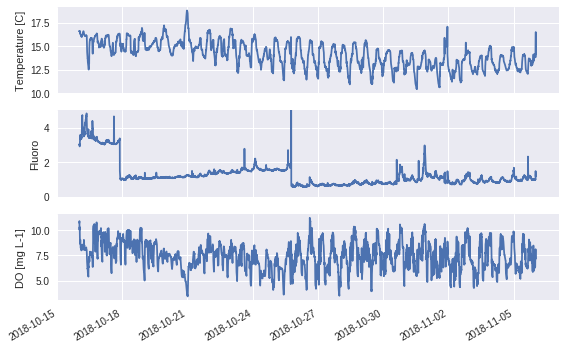

In [10]:
fig, (ax_temp, ax_flr, ax_oxy) = plt.subplots(3, sharex=True)
fig.set_size_inches(9,6)
ax_temp.plot(df['temp_c'])
ax_temp.set_ylabel('Temperature [C]')
ax_flr.plot(df['fluorescence (unknown)'])
ax_flr.set_ylim(0,5)
ax_flr.set_ylabel('Fluoro')
ax_oxy.plot(df['mass_concentration_of_oxygen_in_sea_water (mg.L-1)'])
ax_oxy.set_ylabel("DO [mg L-1]")
fig.autofmt_xdate()

## Now lets look through some of the ATN data

In [11]:
# Different ERDDAP server, but similar request to what we did before
e = ERDDAP(
    server='https://oceanview.pfeg.noaa.gov/erddap',
    protocol='tabledap',
)
e.dataset_id = "gtoppAT"

# We are going to restraint the dataset to the west coast
min_lon,max_lon,min_lat,max_lat= (-130,-116.75,32,42)

e.constraints = {
    'latitude>=': min_lat,
    'latitude<=': max_lat,
    'longitude>=': 360 + min_lon,
    'longitude<=': 360 + max_lon,
}

# We are only going to ask for animals postion, id, and common name
e.variables = [
 'time',
 'latitude',
 'longitude',
 'toppID',
 'commonName',
]

atn_df = e.to_pandas(
    parse_dates=True,
).dropna()
# This will print out all of the common names
[print(name) for name in atn_df['commonName'].unique()]
# Lets Plot it out now
atn_df['longitude (degrees_east)'] = -360+atn_df['longitude (degrees_east)']

Atlantic Sailfish
Black-footed Albatross
Blue Shark
Blue Whale
California Sea Lion
Common Thresher Shark
Fin Whale
Humboldt Squid
Humpback Whale
Juvenile White Shark
Laysan Albatross
Leatherback Sea Turtle
Northern Elephant Seal
Northern Fur Seal
Ocean Sunfish
Oceanic Whitetip Shark
Salmon Shark
Shortfin Mako Shark
Smooth Hammerhead
Sooty Shearwater
South American Sea Lion
Striped Marlin
Swordfish
White Shark


In [12]:
squid = atn_df[atn_df['commonName']=="Humboldt Squid"]
print(squid.head())

                 time (UTC)  latitude (degrees_north)  \
59237  2004-11-19T17:27:53Z                    36.312   
59238  2004-11-19T19:20:23Z                    36.299   
59239  2004-11-19T22:27:32Z                    36.284   
59240  2004-11-20T04:57:04Z                    36.263   
59241  2004-11-20T06:36:54Z                    36.255   

       longitude (degrees_east)   toppID      commonName  
59237                  -123.149  3204005  Humboldt Squid  
59238                  -123.166  3204005  Humboldt Squid  
59239                  -123.176  3204005  Humboldt Squid  
59240                  -123.242  3204005  Humboldt Squid  
59241                  -123.238  3204005  Humboldt Squid  


/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:1852: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


(-125, -120.6)

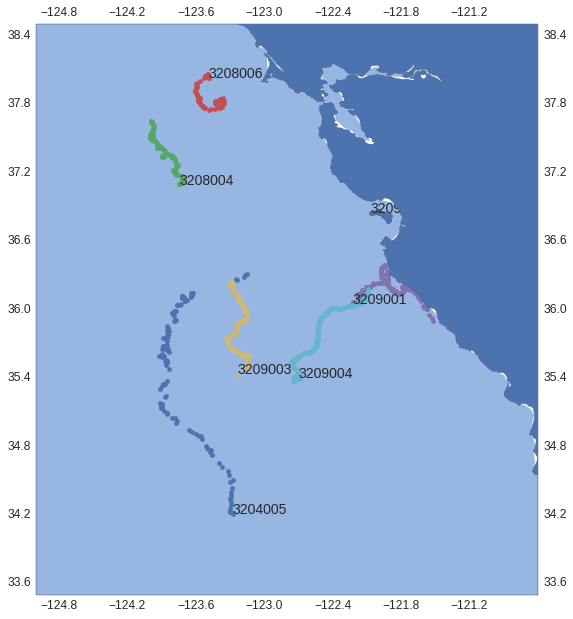

In [13]:
# Lets use the boilerplate make a map, the firstime this is run it will download some data about the coastline
fig, ax = make_map()
for ids in squid['toppID'].unique():
  if ids != 3209002: # We want to skip one deployment that was in Souther California
    single_squid = squid[squid['toppID']==ids]
    ax.scatter(single_squid['longitude (degrees_east)'],single_squid['latitude (degrees_north)'],s=20)
    ax.text(single_squid['longitude (degrees_east)'].iloc[-1],single_squid['latitude (degrees_north)'].iloc[-1],ids,size=14)
 
ax.set_ylim(33.5,38.5)
ax.set_xlim(-125,-120.6)

## Now Lets access some HFR Surface currents

This will be using a different python package called xarray, which is great for retrieving and manipulating netCDF files.

The data is housed on a THREDDS server, so we will need to feed the URL to that dataset to make a request to lazy load the data, meaning we aren't going to access the data until we need it.

In [0]:
hfr_url = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd"
hfr_ds = xr.open_dataset(hfr_url) #
recent_ds = hfr_ds.isel(time=-2)
u = recent_ds['u']
v = recent_ds['v']
U = u / np.sqrt(u**2 + v**2);
V = v / np.sqrt(u**2 + v**2);

speed = np.sqrt(u.values**2 + v.values**2)
xx,yy = np.meshgrid(recent_ds['lon'], recent_ds['lat'])

IndexError: ignored

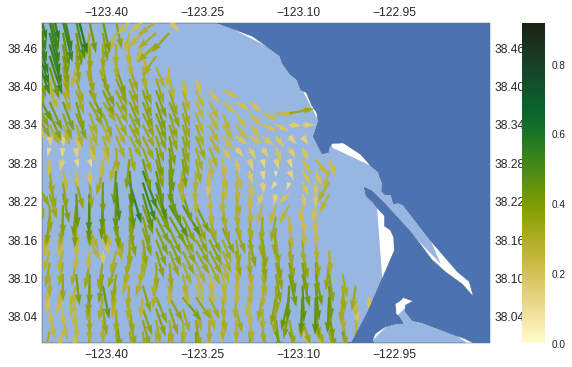

In [61]:
fig, ax = make_map()
ax.set_ylim(38,38.5)
ax.set_xlim(-123.5,-122.8)
Q = ax.quiver(xx, yy, u, v, speed, width=.005, scale_units="xy", scale=8, zorder=10, cmap=cm.speed)
# im = ax.pcolormesh(xx,yy,speed,cmap=cm.speed, zorder=9)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=.45, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(Q, cax=ax_cb)
ax.set_title("2k HFR: "+ str(recent_ds.time.values)[:-10],y=1.04,size=18)


## Lastly lets get the CA ROMS 3km dataset

In [0]:
roms_url = "http://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_DAS.nc"
roms_ds = xr.open_dataset(roms_url) #
nowcast_surface = roms_ds.isel(depth=0,time=-1)

In [0]:
nowcast_temp = nowcast_surface['temp']
xx_roms,yy_roms = np.meshgrid(nowcast_surface['lon'],nowcast_surface['lat'])

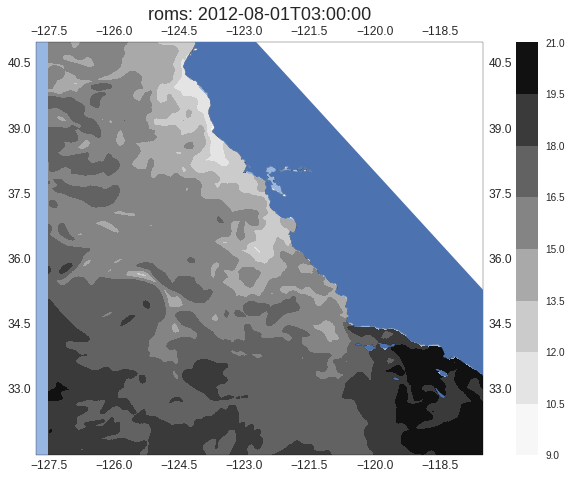

In [67]:
fig, ax = make_map()
ax.set_ylim(31.5,41)
ax.set_xlim(-127.8,-117.5)
im = ax.contourf(xx_roms,yy_roms,nowcast_temp)
ax.set_title("roms: "+ str(roms_ds.time.values[0])[:-10],y=1.04,size=18)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.45, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(im, cax=ax_cb)